In [1]:
!pip install vaderSentiment
!pip install scikit-surprise
!pip install folium
!pip install surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469547 sha256=8df39a064b3d74f7adafb9eea64a51cd660ff32165e9d3cab1bd57a4c09e1785
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings

# sklearn ML tools
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split as sklearn_train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Advanced ML
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Recommendation system
#from surprise import Reader, Dataset, SVD, accuracy, BaselineOnly, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

# Utilities
import joblib
import random

# Plotting config
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
dublin_encoded_df = pd.read_csv('dublin_encoded_df.csv')
dublin_encoded_df.head()

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood_cleansed_freq,property_type_freq
0,44077,193005,1.00,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,0.13507,0.006663
1,85156,193005,1.00,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,0.13507,0.006663
2,159889,766611,1.00,0,3.0,1.0,2.0,1.0,1.0,45.0,4.755714,202500,0.68080,0.207147
3,165828,790601,0.75,0,4.0,5.0,1.0,1.0,3.0,256.0,4.691429,7056,0.68080,0.215627
4,165829,790601,0.75,0,4.0,5.0,1.0,1.0,3.0,228.0,4.681429,7225,0.68080,0.215627


In [38]:
dublin_aggregated_df = pd.read_csv('dublin_aggregated_df.csv')
dublin_aggregated_df.head()

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood_cleansed,property_type,neighbourhood_cleansed_freq,property_type_freq
0,44077,193005,1.00,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,Dn Laoghaire-Rathdown,Private room in bungalow,0.13507,0.006663
1,85156,193005,1.00,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,Dn Laoghaire-Rathdown,Private room in bungalow,0.13507,0.006663
2,159889,766611,1.00,0,3.0,1.0,2.0,1.0,1.0,45.0,4.755714,202500,Dublin City,Private room in home,0.68080,0.207147
3,165828,790601,0.75,0,4.0,5.0,1.0,1.0,3.0,256.0,4.691429,7056,Dublin City,Entire rental unit,0.68080,0.215627
4,165829,790601,0.75,0,4.0,5.0,1.0,1.0,3.0,228.0,4.681429,7225,Dublin City,Entire rental unit,0.68080,0.215627


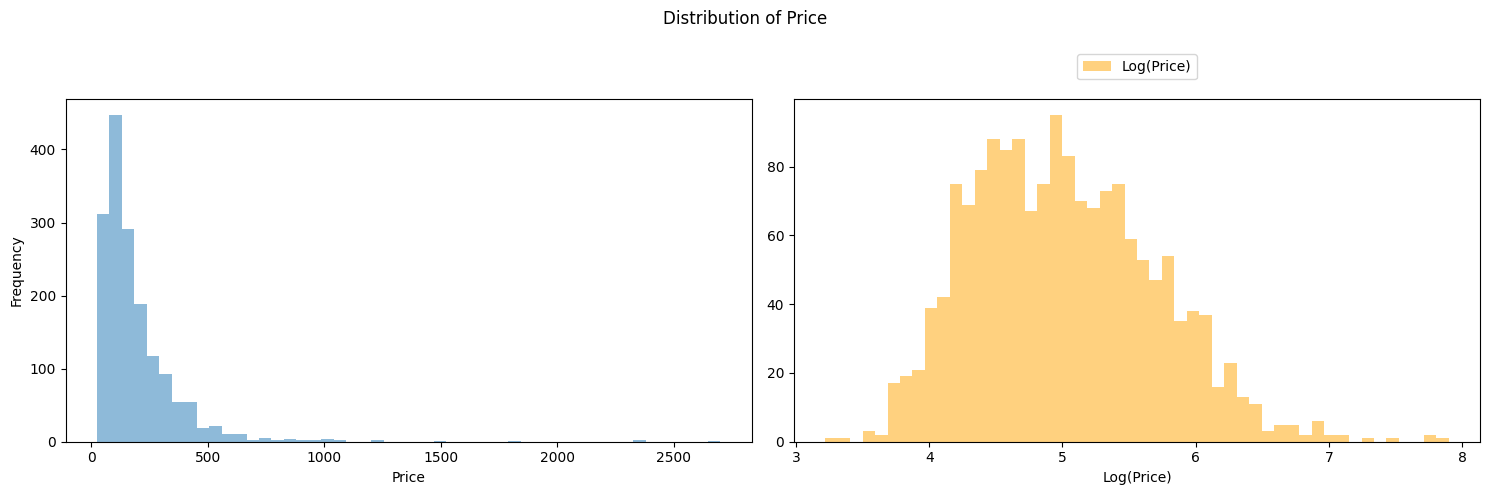

In [6]:
# split data
X = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y = dublin_encoded_df['price']

# log transform y variable(price)
y_log = np.log(y)
y_log.name = "log(price)"

# plot the raw y variable and log transformed y variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # figure with 2 subplots

# Plot original price distribution
ax[0].hist(y, bins=50, alpha=0.5, label="Price")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")

# Plot log-transformed price distribution
ax[1].hist(y_log, bins=50, color="orange", alpha=0.5, label="Log(Price)")
ax[1].set_xlabel("Log(Price)")

# Add legend
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

# main title
plt.suptitle("Distribution of Price")

plt.tight_layout()
plt.show()

The raw prices are right-skewed, with most listings priced under £500, and a few very expensive outliers. After log transformation, the distribution becomes more normal (bell-shaped) — making it better suited for regression models. Log transformation helps stabilize variance, reduce skewness, and improve model performance.

In [7]:
#LOG transform target variable price.
X_log = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y_log = np.log(dublin_encoded_df['price'])

In [8]:
# Split data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = sklearn_train_test_split(X_log, y_log, test_size=0.2, random_state=42)

## Modeling
- Regression Models - for price prediction
- Collaborative-Filtering Models - for personalized airbnb recommendation
1. Regression Models
We'll create various models for this project. We'll use a Linear Regression Model as the baseline. We'll also build a Decision Tree, Random Forest, KNN, Polynomial Regresssion, XGBoost and LightGBM . RMSE will be our evaluation metric.

**Baseline Model: Linear Regression**

**Pipeline Setup**

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

model_log_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

**Fit + Evaluate Log Model**

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def fit_log_results(pipe, X_train, X_test, y_train, y_test):
    """
    Fits pipeline on log-transformed target and returns metrics in log scale
    """
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Log-scale RMSE
    train_rmse = mean_squared_error(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)

    # MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # R2
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train RMSE (log-scale): {train_rmse:.4f}")
    print(f"Test RMSE (log-scale): {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("------------------------------------")

**Cross-Validation Evaluation**

In [11]:
from sklearn.model_selection import cross_val_predict

def cross_validate_log_results(pipe, X, y, cv=5):
    """
    Performs cross-validation and returns log-scale metrics
    """
    y_pred = cross_val_predict(pipe, X, y, cv=cv)

    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"Cross-validated RMSE (log-scale): {rmse:.4f}")
    print(f"Cross-validated MAE: {mae:.4f}")
    print(f"Cross-validated R² Score: {r2:.4f}")
    print("------------------------------------")

In [12]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def learn_curves(pipe, X, y, cv=5):
    """
    Generates learning curves in log-scale MSE
    """
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Error')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error (log-scale)')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

**Run Everything**

Train RMSE (log-scale): 0.1921
Test RMSE (log-scale): 0.1936
Train MAE: 0.3223, Test MAE: 0.3461
R² Score: 0.6016
------------------------------------
Cross-validated RMSE (log-scale): 0.1981
Cross-validated MAE: 0.3305
Cross-validated R² Score: 0.5794
------------------------------------


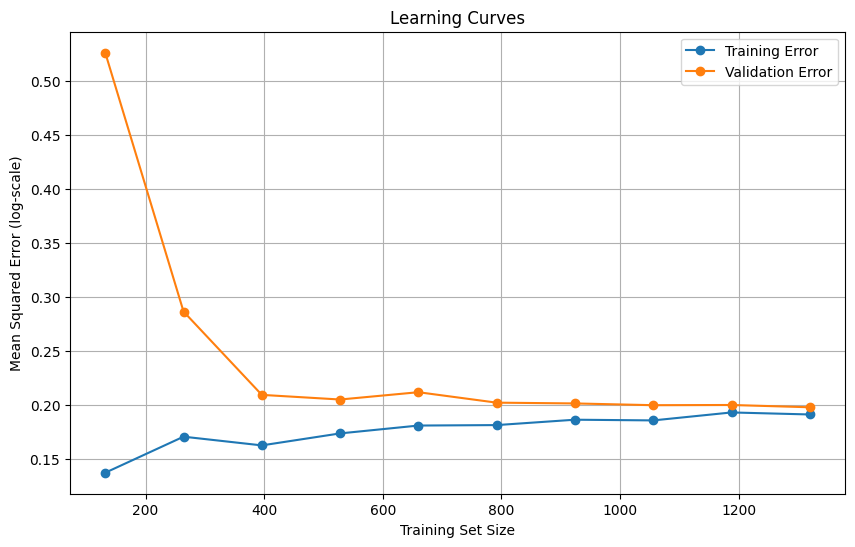

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit & evaluate
fit_log_results(model_log_pipeline, X_train_log, X_test_log, y_train_log, y_test_log)

# Cross-validated scores
cross_validate_log_results(model_log_pipeline, X_log, y_log, cv=kf)

# Plot learning curves
learn_curves(model_log_pipeline, X_log, y_log, cv=kf)

The Linear Regression model shows to perform reasonably well because we can see that the Training vs. Test RMSE (log-scale): 0.1921 vs. 0.1936 looks very close, indicating low overfitting. While the MAE: 0.32 (train) vs. 0.35 (test) shows small error, suggesting good average prediction accuracy. R² Score: 0.60 the model explains around 60% of the variance in the data.

Cross-validation results are consistent with test performance, implying reliable generalization. For use to see further gains we try other more complex models.

**Linear Regression (with PCA)**

Next, we reduce the dimensionality of the data using PCA to retain the most important features, simplifying the model while preserving essential information.

Train RMSE (log-scale): 0.2239
Test RMSE (log-scale): 0.2971
Train MAE: 0.3552, Test MAE: 0.3914
R² Score: 0.3887
------------------------------------
Cross-validated RMSE (log-scale): 0.2452
Cross-validated MAE: 0.3658
Cross-validated R² Score: 0.4794
------------------------------------


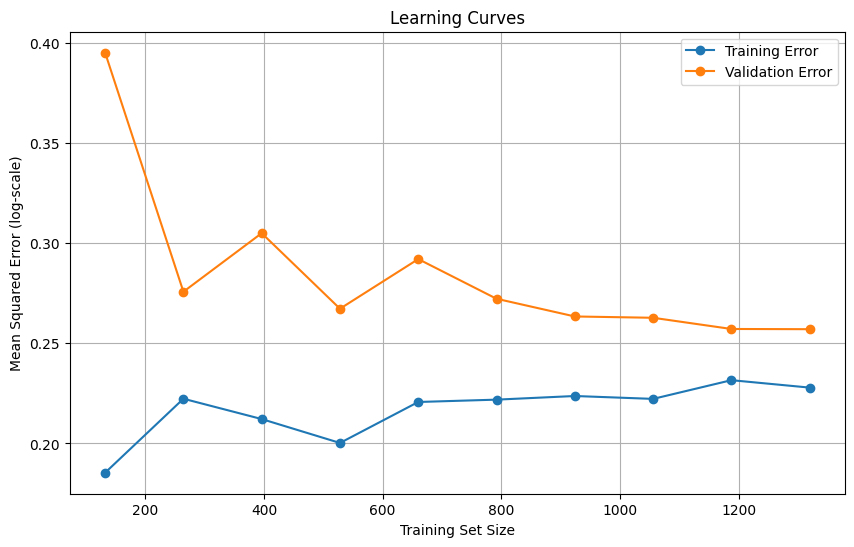

In [14]:
# pipeline including scaling and PCA
baseline_model_pca_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=9)), # pca
    ('linreg', LinearRegression()) # linear regression model
])

# Fit and evaluate the model
fit_log_results(baseline_model_pca_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(baseline_model_pca_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(baseline_model_pca_log, X_log, y_log)

This Linear Regression with PCA model ends up performming worse than the standard linear regression because there are Higher errors in the Train RMSE: 0.2239 looking higher than before and Test RMSE: 0.2971 shows worse generalization, Lower R² Score: 0.39 as agaisnt the previous LR 0.60. The LR with PCA model explains less variance. Cross-validation confirms poorer performance: lower R² and higher error metrics. PCA reduced model performance due to information loss in dimensionality reduction.

**Decision Tree Model**

In [15]:
dt_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('dt', DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42))
])

Train RMSE (log-scale): 0.1381
Test RMSE (log-scale): 0.1725
Train MAE: 0.2798, Test MAE: 0.3182
R² Score: 0.6451
------------------------------------
Cross-validated RMSE (log-scale): 0.1841
Cross-validated MAE: 0.3168
Cross-validated R² Score: 0.6091
------------------------------------


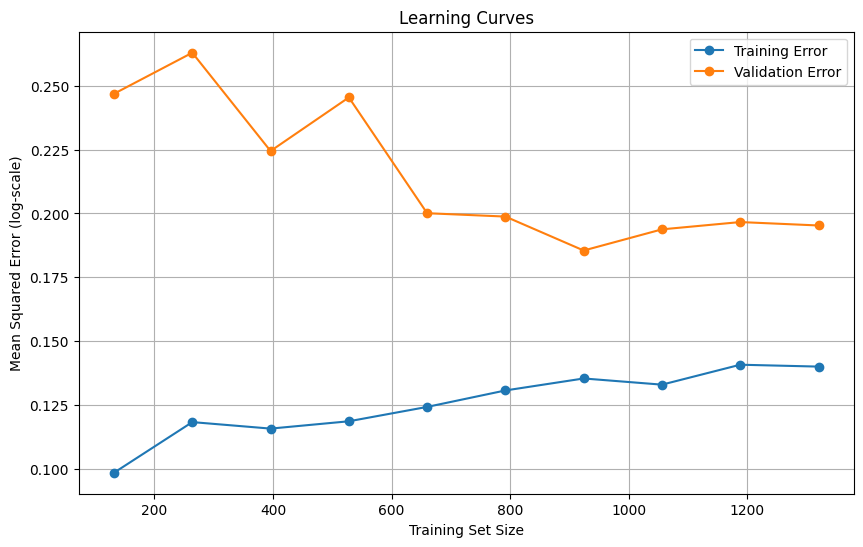

In [16]:
# Fit and evaluate the model
fit_log_results(dt_model_log, X_train_log, X_test_log, y_train_log, y_test_log)

# Call the function to cross-validate the pipeline
cross_validate_log_results(dt_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(dt_model_log, X_log, y_log)

This Decision Tree model shows Lower errors than linear models between the Train RMSE: 0.1381 (better fit) and Test RMSE: 0.1725 (better generalization) Higher R² Score: 0.6451 on test, indicating it explains 64.5% of variance, better than linear regression Cross-validation confirms strong performance, RMSE and R² are consistent, indicating stable results Although we there is a Learning curve gap between train and validation errors suggests some overfitting, but still generalizes well. Decision Tree performs well with good accuracy and reasonable generalization, better than the linear models here.

**Random Forest**

In [17]:
rf_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('rf', RandomForestRegressor(random_state=42))
])

Train RMSE (log-scale): 0.0198
Test RMSE (log-scale): 0.1370
Train MAE: 0.0986, Test MAE: 0.2749
R² Score: 0.7181
------------------------------------
Cross-validated RMSE (log-scale): 0.1391
Cross-validated MAE: 0.2647
Cross-validated R² Score: 0.7046
------------------------------------


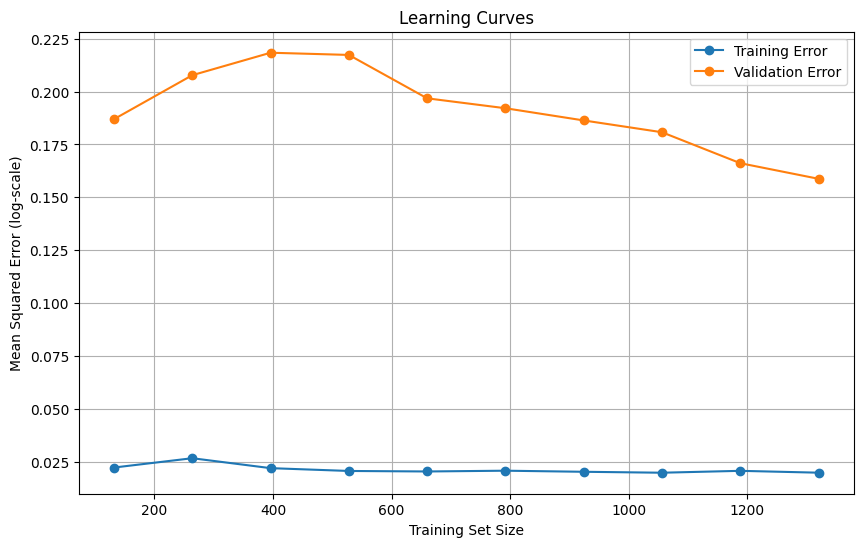

In [18]:
# Fit and evaluate the model
fit_log_results(rf_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(rf_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(rf_model_log, X_log, y_log)

This Random Forest model shows Very low training error (RMSE 0.0198), indicating excellent fit on training data. Test error is higher but still low (RMSE 0.1370), showing good generalization. High R² score (0.7181) on test set, explaining about 72% of variance. Cross-validation results confirm stability and strong performance (R² = 0.70). The gap between training and validation error suggests some overfitting but controlled. Random Forest outperforms previous models with high accuracy and robust generalization.

**KNN Regression Model**

In [19]:
from sklearn.preprocessing import PolynomialFeatures
# model pipeline
knn_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=10)),
    ('knn', KNeighborsRegressor(n_neighbors=13, metric='euclidean'))
])

Train RMSE (log-scale): 0.1749
Test RMSE (log-scale): 0.2132
Train MAE: 0.3093, Test MAE: 0.3477
R² Score: 0.5613
------------------------------------
Cross-validated RMSE (log-scale): 0.2080
Cross-validated MAE: 0.3414
Cross-validated R² Score: 0.5583
------------------------------------


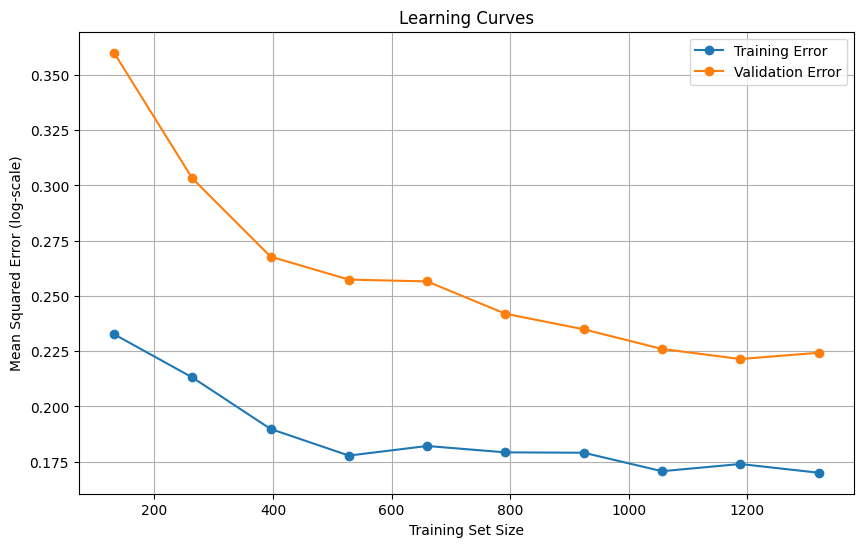

In [20]:
# Fit and evaluate the model
fit_log_results(knn_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# Cross-validate the pipeline
cross_validate_log_results(knn_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(knn_model_log, X_log, y_log)

This KNN Regression model shows Moderate training error (RMSE 0.1749) and higher test error (RMSE 0.2132), indicating some overfitting. Test R² score of 0.5613 means it explains about 56% of the variance which is quite low. Cross-validation results are consistent, confirming moderate predictive performance. Errors (MAE) are higher compared to Random Forest and Decision Tree models. KNN performs reasonably but less accurate and less generalizable than Random Forest or Decision Tree.

**Tuned KNN Regression Model (with Grid Search)**

In [21]:
from sklearn.model_selection import GridSearchCV
# parameter grid
param_grid = {
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__metric': ['euclidean', 'manhatt/an', 'minkowski']  # Corrected 'knn_metric' to 'knn__metric'
}

# GridSearchCV object
grid_search = GridSearchCV(knn_model_log, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_log, y_train_log)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 10}
Best score:  -0.20705561910426856


In [22]:
# Create the final model using the best parameters
knn_model_gs_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=10)), # pca
    ('knn', KNeighborsRegressor(n_neighbors=grid_search.best_params_['knn__n_neighbors'],
                                 metric=grid_search.best_params_['knn__metric']))  # Uses best parameters
])

Train RMSE (log-scale): 0.1639
Test RMSE (log-scale): 0.2078
Train MAE: 0.2991, Test MAE: 0.3422
R² Score: 0.5726
------------------------------------
Cross-validated RMSE (log-scale): 0.2049
Cross-validated MAE: 0.3375
Cross-validated R² Score: 0.5649
------------------------------------


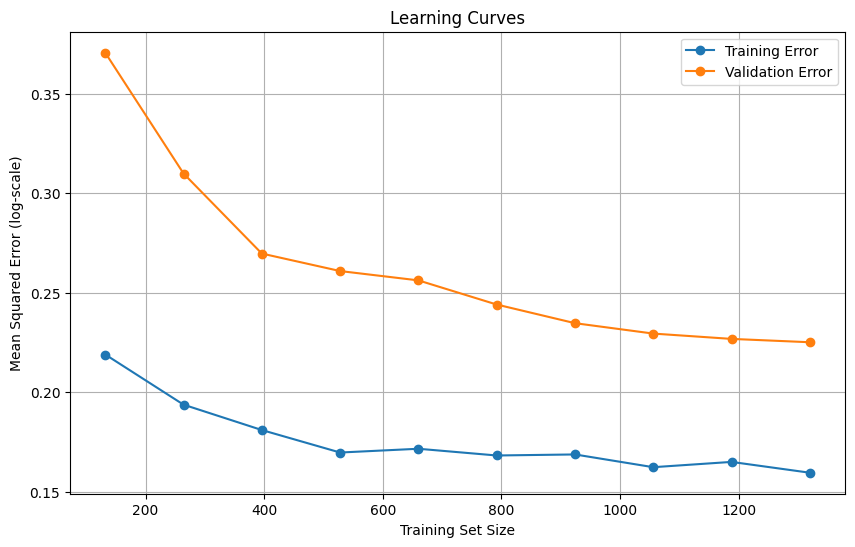

In [23]:
# Fit and evaluate the final model
fit_log_results(knn_model_gs_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(knn_model_gs_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(knn_model_gs_log, X_log, y_log)

This KNN Regression with Grid Search shows Best hyperparameters: 10 neighbors, Euclidean distance. Training RMSE (0.1639) and Test RMSE (0.2078) are close, indicating reduced overfitting. R² of 0.5726 suggests moderate explanatory power. Cross-validation metrics confirm consistent performance. Slight improvement over previous KNN model without tuning. Hyperparameter tuning improved KNN's stability and performance moderately.

**Polynomial Regression Model**

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Creates polynomial features
    ('scaler', StandardScaler()),  # Standardizes the data
    ('linreg', LinearRegression())  # Fits linear regression on polynomial features
])

Train RMSE (log-scale): 0.1419
Test RMSE (log-scale): 0.2394
Train MAE: 0.2798, Test MAE: 0.3412
R² Score: 0.5074
------------------------------------
Cross-validated RMSE (log-scale): 0.2680
Cross-validated MAE: 0.3214
Cross-validated R² Score: 0.4309
------------------------------------


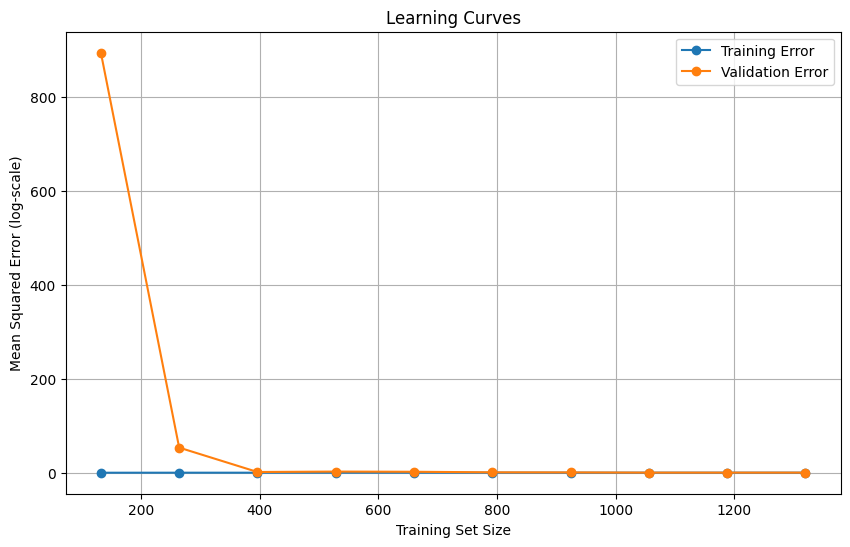

In [25]:
# Fit and evaluate the model
fit_log_results(poly_model, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(poly_model, X_log, y_log, cv=kf)
# learn curves
learn_curves(poly_model, X_log, y_log)

This Polynomial Regression result shows Low training RMSE (0.1419) but higher test RMSE (0.2394), indicating some overfitting. Moderate R² of 0.5074 suggests reasonable fit but less generalization. Cross-validation results show a drop in performance (R²: 0.4309), confirming overfitting. Training error curve drops quickly, validation error decreases but remains higher.

Model fits training data well but struggles to generalize, indicating moderate overfitting.

**XGBoost Model**

In [26]:
# model pipeline
xgb_model_log = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5))
])

Train RMSE (log-scale): 0.0342
Test RMSE (log-scale): 0.1340
Train MAE: 0.1399, Test MAE: 0.2759
R² Score: 0.7244
------------------------------------
Cross-validated RMSE (log-scale): 0.1336
Cross-validated MAE: 0.2638
Cross-validated R² Score: 0.7162
------------------------------------


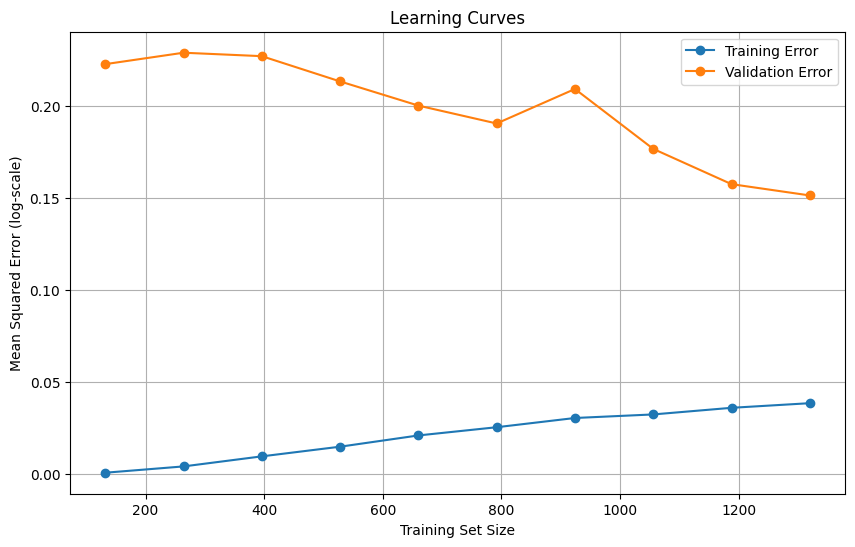

In [27]:
# Fit and evaluate the model
fit_log_results(xgb_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(xgb_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(xgb_model_log, X_log, y_log)

This XGBoost model shows a Very low training error (RMSE 0.0342) and relatively low test error (RMSE 0.1340), indicating strong fit. High R² (0.7244) on test data shows good predictive power. Cross-validation metrics are consistent, confirming model generalizes well. The Learning curves show some gap but decreasing validation error, suggesting manageable complexity without severe overfitting. XGBoost model shows Strong, well-generalizing model with good accuracy and robustness.

**LightGBM Model**

Train RMSE (log-scale): 0.0320
Test RMSE (log-scale): 0.1282
Train MAE: 0.1303, Test MAE: 0.2718
R² Score: 0.7362
------------------------------------
Cross-validated RMSE (log-scale): 0.1343
Cross-validated MAE: 0.2665
Cross-validated R² Score: 0.7148
------------------------------------


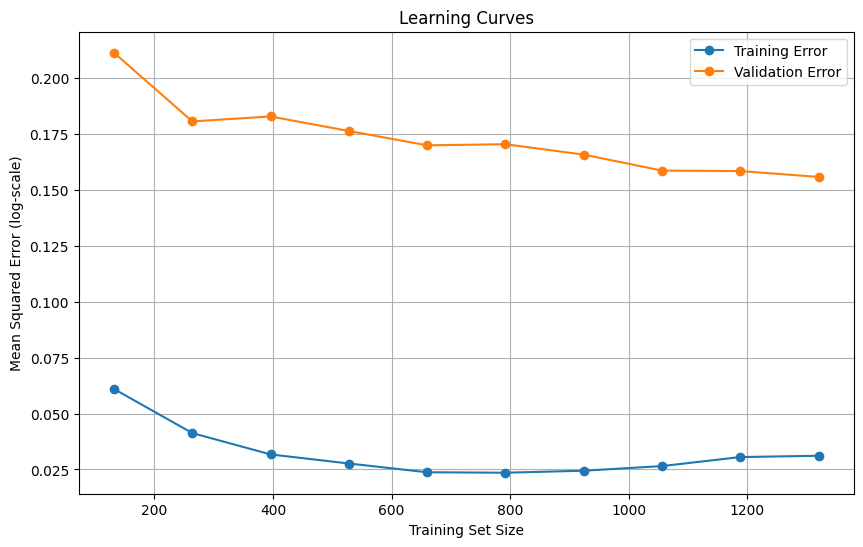

In [28]:
lgb_model_log = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', lgb.LGBMRegressor(objective='regression', verbose=-1))
])

fit_log_results(lgb_model_log, X_train_log,  X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(lgb_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(lgb_model_log, X_log, y_log)

This LightGBM model shows Low training error (RMSE 0.0313) and low test error (RMSE 0.1282), indicating a strong fit. High R² on test (0.7362) and cross-validation (0.716) indicates good generalization and predictive power. Learning curves suggest some gap between training and validation error but no severe overfitting. Consistent cross-validation results confirm model robustness.

LightGBM performs very well, slightly better than XGBoost here, with strong accuracy and good generalization.

**Neural Network Model**

In [29]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

# Define neural network model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', kernel_initializer='glorot_uniform', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_initializer=HeNormal()),
        Dense(1)  # Regression output layer
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='mse'
    )
    return model

# Initialize and train the model
input_dim = X_train_scaled.shape[1]
nn_model = create_nn_model(input_dim)

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with scaled data
history = nn_model.fit(
    X_train_scaled, y_train_log,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions using scaled data
y_train_pred = nn_model.predict(X_train_scaled).flatten()
y_test_pred = nn_model.predict(X_test_scaled).flatten()

# Evaluation
train_rmse = np.exp(mean_squared_error(y_train_log, y_train_pred))-1
test_rmse = np.exp(mean_squared_error(y_test_log, y_test_pred))-1
train_mae = mean_absolute_error(y_train_log, y_train_pred)
test_mae = mean_absolute_error(y_test_log, y_test_pred)
train_r2 = r2_score(y_train_log, y_train_pred)
test_r2 = r2_score(y_test_log, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.2f}")

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 24.5162 - val_loss: 6.2548
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2913 - val_loss: 1.4012
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4501 - val_loss: 1.0740
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9131 - val_loss: 0.7446
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5954 - val_loss: 0.7647
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2621 - val_loss: 0.4805
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1500 - val_loss: 0.6411
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1107 - val_loss: 0.6140
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9931 - val_loss: 0.4778
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8893 - val_loss: 0.5257
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7821 - val_loss: 0.5091
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

The Neural Network model shows Good fit with close train and test RMSE (0.15 vs 0.17) and MAE (0.27 vs 0.31), indicating low overfitting. R² of 0.67 suggests strong predictive performance.

A well-balanced model with solid accuracy and generalization.

**Save Best Model**

While Random Forest and XGBoost also showed strong performance, LightGBM had slightly better test error and R². LightGBM offers the best balance of accuracy, generalization, and efficiency, making it scientifically the most suitable model for deployment in this regression task. Because LightGBM is a gradient boosting framework that builds ensembles of decision trees sequentially, correcting previous errors. This leads to highly accurate, robust models that capture complex nonlinear relationships in the data. it is also good in Handling of Large Feature Spaces, Regularization & Flexibility i.e It supports various regularization techniques (e.g., feature fraction, bagging) that help avoid overfitting and improve generalization, evident in the tight train-test error gap.

In [30]:
# Fit model
#lgb_model_log.fit(X_train_log, y_train_log)

# Save model to a file
#joblib.dump(lgb_model_log, 'lgb_model_log.pkl')

#print("Model saved as lgb_model_log.pkl")

**Suggest Price to Property Owners**

In [40]:
# Load the saved model from the pickle file
saved_model = joblib.load('lgb_model_log.pkl')

# Prompt the user to enter the property details
host_id = input("Enter the host ID (e.g. 1952066, 59072 etc): ")
host_response_rate = float(input("Enter the host response rate (as a decimal): "))
host_is_superhost = input("Is the host a superhost? (yes/no): ")
host_listings_count = int(input("Enter the number of host listings: "))
accommodates = int(input("Enter the number of people the property can accommodate: "))
bathrooms = float(input("Enter the number of bathrooms: "))
bedrooms = float(input("Enter the number of bedrooms: "))
beds = float(input("Enter the number of beds: "))
avg_rating = float(input("Enter the average rating: "))
number_of_reviews = int(input("Enter the number of reviews: "))
neighbourhood_cleansed = input("Enter the neighbourhood: ")
property_type = input("Enter the property type (e.g., Entire home, Private room etc): ")

# Frequency encode the neighbourhood and property type
neighbourhood_cleansed_freq = dublin_aggregated_df[dublin_aggregated_df['neighbourhood_cleansed'] == neighbourhood_cleansed]['neighbourhood_cleansed_freq'].mean()
property_type_freq = dublin_aggregated_df[dublin_aggregated_df['property_type'] == property_type]['property_type_freq'].mean()

# Create a DataFrame with the property details
property_details = pd.DataFrame({
    'host_id': [host_id],
    'host_response_rate': [host_response_rate],
    'host_is_superhost': [1 if host_is_superhost.lower() == 'yes' else 0],
    'host_listings_count': [host_listings_count],
    'accommodates': [accommodates],
    'bathrooms': [bathrooms],
    'bedrooms': [bedrooms],
    'beds': [beds],
    'avg_rating': [avg_rating],
    'number_of_reviews': [number_of_reviews],
    'neighbourhood_cleansed_freq': [neighbourhood_cleansed_freq],
    'property_type_freq': [property_type_freq]
})

# Make a prediction using the saved model
log_price = saved_model.predict(property_details)
price = np.exp(log_price[0])

# Print the predicted price
print(f"The predicted price for the property is GBP {price:.2f}")

Enter the host ID (e.g. 1952066, 59072 etc): 790601
Enter the host response rate (as a decimal): 0.75
Is the host a superhost? (yes/no): no
Enter the number of host listings: 4
Enter the number of people the property can accommodate: 5
Enter the number of bathrooms: 1
Enter the number of bedrooms: 1
Enter the number of beds: 3
Enter the average rating: 4.691429
Enter the number of reviews: 7225
Enter the neighbourhood: Dublin City
Enter the property type (e.g., Entire home, Private room etc): Entire rental unit
The predicted price for the property is GBP 227.38
